<a href="https://colab.research.google.com/github/JAG-91/Flights-on-time/blob/main/Flights_On_Time_Data_Science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerias

In [6]:

import pandas as pd
import numpy as np
import zipfile
import os
import gc
import json
import subprocess
import sys
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
import kagglehub
from kagglehub import KaggleDatasetAdapter
import os


from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, recall_score
import xgboost as xgb


import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import resample

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
    f1_score,
    recall_score,
    precision_score
)
import warnings
warnings.filterwarnings('ignore')

#Carga de datos

In [7]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "flight_data_2024.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "hrishitpatil/flight-data-2024",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", df.head())

Using Colab cache for faster access to the 'flight-data-2024' dataset.
First 5 records:    year  month  day_of_month  day_of_week     fl_date op_unique_carrier  \
0  2024      1             1            1  2024-01-01                9E   
1  2024      1             1            1  2024-01-01                9E   
2  2024      1             1            1  2024-01-01                9E   
3  2024      1             1            1  2024-01-01                9E   
4  2024      1             1            1  2024-01-01                9E   

   op_carrier_fl_num origin origin_city_name origin_state_nm  ... diverted  \
0             4814.0    JFK     New York, NY        New York  ...        0   
1             4815.0    MSP  Minneapolis, MN       Minnesota  ...        0   
2             4817.0    JFK     New York, NY        New York  ...        0   
3             4817.0    RIC     Richmond, VA        Virginia  ...        0   
4             4818.0    DTW      Detroit, MI        Michigan  ...      

In [8]:


# Diccionario de Aerolíneas (Manual)
mapeo_aerolineas = {
    '9E': 1, 'AA': 2, 'AS': 3, 'B6': 4, 'DL': 5, 'F9': 6, 'G4': 7,
    'HA': 8, 'MQ': 9, 'NK': 10, 'OH': 11, 'OO': 12, 'UA': 13, 'WN': 14, 'YX': 15
}

# Diccionario de Aeropuertos

diccionario_aeropuertos = {
    'ABE': 1, 'ABI': 2, 'ABQ': 3, 'ABR': 4, 'ABY': 5, 'ACK': 6, 'ACT': 7,
    'ACV': 8, 'ACY': 9, 'ADK': 10, 'ADQ': 11, 'AEX': 12, 'AGS': 13, 'AKN': 14,
    'ALB': 15, 'ALW': 16, 'AMA': 17, 'ANC': 18, 'APN': 19, 'ASE': 20, 'ATL': 21,
    'ATW': 22, 'AUS': 23, 'AVL': 24, 'AVP': 25, 'AZA': 26, 'AZO': 27, 'BDL': 28,
    'BET': 29, 'BFF': 30, 'BFL': 31, 'BGM': 32, 'BGR': 33, 'BHM': 34, 'BIH': 35,
    'BIL': 36, 'BIS': 37, 'BJI': 38, 'BLI': 39, 'BLV': 40, 'BMI': 41, 'BNA': 42,
    'BOI': 43, 'BOS': 44, 'BPT': 45, 'BQK': 46, 'BQN': 47, 'BRD': 48, 'BRO': 49,
    'BRW': 50, 'BTM': 51, 'BTR': 52, 'BTV': 53, 'BUF': 54, 'BUR': 55, 'BWI': 56,
    'BZN': 57, 'CAE': 58, 'CAK': 59, 'CDC': 60, 'CDV': 61, 'CHA': 62, 'CHO': 63,
    'CHS': 64, 'CID': 65, 'CIU': 66, 'CKB': 67, 'CLE': 68, 'CLL': 69, 'CLT': 70,
    'CMH': 71, 'CMI': 72, 'CMX': 73, 'CNY': 74, 'COD': 75, 'COS': 76, 'COU': 77,
    'CPR': 78, 'CRP': 79, 'CRW': 80, 'CSG': 81, 'CVG': 82, 'CWA': 83, 'CYS': 84,
    'DAB': 85, 'DAL': 86, 'DAY': 87, 'DCA': 88, 'DDC': 89, 'DEC': 90, 'DEN': 91,
    'DFW': 92, 'DHN': 93, 'DIK': 94, 'DLG': 95, 'DLH': 96, 'DRO': 97, 'DSM': 98,
    'DTW': 99, 'DVL': 100, 'EAR': 101, 'EAU': 102, 'ECP': 103, 'EGE': 104, 'EKO': 105,
    'ELM': 106, 'ELP': 107, 'ESC': 108, 'EUG': 109, 'EVV': 110, 'EWN': 111, 'EWR': 112,
    'EYW': 113, 'FAI': 114, 'FAR': 115, 'FAT': 116, 'FAY': 117, 'FCA': 118, 'FLG': 119,
    'FLL': 120, 'FNT': 121, 'FOD': 122, 'FSD': 123, 'FSM': 124, 'FWA': 125, 'GCC': 126,
    'GCK': 127, 'GEG': 128, 'GFK': 129, 'GGG': 130, 'GJT': 131, 'GNV': 132, 'GPT': 133,
    'GRB': 134, 'GRI': 135, 'GRK': 136, 'GRR': 137, 'GSO': 138, 'GSP': 139, 'GST': 140,
    'GTF': 141, 'GTR': 142, 'GUC': 143, 'GUM': 144, 'HDN': 145, 'HGR': 146, 'HHH': 147,
    'HIB': 148, 'HLN': 149, 'HNL': 150, 'HOB': 151, 'HOU': 152, 'HPN': 153, 'HRL': 154,
    'HSV': 155, 'HTS': 156, 'HYA': 157, 'HYS': 158, 'IAD': 159, 'IAG': 160, 'IAH': 161,
    'ICT': 162, 'IDA': 163, 'ILM': 164, 'IMT': 165, 'IND': 166, 'INL': 167, 'ISP': 168,
    'ITH': 169, 'ITO': 170, 'JAC': 171, 'JAN': 172, 'JAX': 173, 'JFK': 174, 'JLN': 175,
    'JMS': 176, 'JNU': 177, 'JST': 178, 'KOA': 179, 'KTN': 180, 'LAN': 181, 'LAR': 182,
    'LAS': 183, 'LAW': 184, 'LAX': 185, 'LBB': 186, 'LBE': 187, 'LBF': 188, 'LBL': 189,
    'LCH': 190, 'LCK': 191, 'LEX': 192, 'LFT': 193, 'LGA': 194, 'LGB': 195, 'LIH': 196,
    'LIT': 197, 'LNK': 198, 'LRD': 199, 'LSE': 200, 'LWS': 201, 'MAF': 202, 'MBS': 203,
    'MCI': 204, 'MCO': 205, 'MCW': 206, 'MDT': 207, 'MDW': 208, 'MEI': 209, 'MEM': 210,
    'MFE': 211, 'MFR': 212, 'MGM': 213, 'MGW': 214, 'MHK': 215, 'MHT': 216, 'MIA': 217,
    'MKE': 218, 'MLB': 219, 'MLI': 220, 'MLU': 221, 'MOB': 222, 'MOT': 223, 'MQT': 224,
    'MRY': 225, 'MSN': 226, 'MSO': 227, 'MSP': 228, 'MSY': 229, 'MTJ': 230, 'MVY': 231,
    'MYR': 232, 'OAJ': 233, 'OAK': 234, 'OGG': 235, 'OKC': 236, 'OMA': 237, 'OME': 238,
    'ONT': 239, 'ORD': 240, 'ORF': 241, 'ORH': 242, 'OTH': 243, 'OTZ': 244, 'PAE': 245,
    'PBG': 246, 'PBI': 247, 'PDX': 248, 'PGD': 249, 'PHL': 250, 'PHX': 251, 'PIA': 252,
    'PIB': 253, 'PIE': 254, 'PIH': 255, 'PIT': 256, 'PLN': 257, 'PNS': 258, 'PPG': 259,
    'PQI': 260, 'PRC': 261, 'PSC': 262, 'PSE': 263, 'PSG': 264, 'PSM': 265, 'PSP': 266,
    'PVD': 267, 'PVU': 268, 'PWM': 269, 'RAP': 270, 'RDD': 271, 'RDM': 272, 'RDU': 273,
    'RFD': 274, 'RHI': 275, 'RIC': 276, 'RIW': 277, 'RKS': 278, 'RNO': 279, 'ROA': 280,
    'ROC': 281, 'ROW': 282, 'RST': 283, 'RSW': 284, 'SAF': 285, 'SAN': 286, 'SAT': 287,
    'SAV': 288, 'SBA': 289, 'SBN': 290, 'SBP': 291, 'SCC': 292, 'SCE': 293, 'SCK': 294,
    'SDF': 295, 'SEA': 296, 'SFB': 297, 'SFO': 298, 'SGF': 299, 'SGU': 300, 'SHR': 301,
    'SHV': 302, 'SIT': 303, 'SJC': 304, 'SJT': 305, 'SJU': 306, 'SLC': 307, 'SLN': 308,
    'SMF': 309, 'SMX': 310, 'SNA': 311, 'SPI': 312, 'SPN': 313, 'SPS': 314, 'SRQ': 315
}

# =============================================================================
# 2. SELECCIÓN DE COLUMNAS Y TIPOS
# =============================================================================
columnas_a_usar = [
    'op_unique_carrier',
    'origin',
    'dest',
    'origin_state_nm',  # Estados incluidos
    'dest_state_nm',    # Estados incluidos
    'crs_dep_time',
    'dep_delay',
    'arr_delay',
    'distance',
    'carrier_delay',
    'weather_delay',
    'nas_delay',
    'security_delay',
    'late_aircraft_delay',
    'cancelled',
    'diverted',
    'fl_date'
]

dtype_dict = {
    'op_unique_carrier': 'object',
    'origin': 'object',
    'dest': 'object',
    'origin_state_nm': 'object',
    'dest_state_nm': 'object',
    'crs_dep_time': 'float32',
    'dep_delay': 'float32',
    'arr_delay': 'float32',
    'distance': 'int32',
    'carrier_delay': 'float32',
    'weather_delay': 'float32',
    'nas_delay': 'float32',
    'security_delay': 'float32',
    'late_aircraft_delay': 'float32',
    'cancelled': 'int8',
    'diverted': 'int8',
    'fl_date': 'object'
}

# =============================================================================
# 3. LIMPIEZA Y TRANSFORMACIÓN
# =============================================================================
print("\n🧹 Filtrando y transformando...")

# Seleccionar y tipar columnas
# Capture the original df columns to check for 'fl_date' later if it was intended
initial_df_columns = set(df.columns) # Store original columns
actual_cols_to_use = [col for col in columnas_a_usar if col in df.columns]
actual_dtype_dict = {col: dtype_dict[col] for col in actual_cols_to_use}
df = df[actual_cols_to_use].astype(actual_dtype_dict).copy()

# Filtrar vuelos no operados
if 'cancelled' in df.columns and 'diverted' in df.columns:
    df = df[(df['cancelled'] == 0) & (df['diverted'] == 0)].copy()
    df.drop(columns=['cancelled', 'diverted'], inplace=True)
elif 'cancelled' in df.columns:
    df = df[(df['cancelled'] == 0)].copy()
    df.drop(columns=['cancelled'], inplace=True)
elif 'diverted' in df.columns:
    df = df[(df['diverted'] == 0)].copy()
    df.drop(columns=['diverted'], inplace=True)

# Eliminar filas sin arr_delay
df.dropna(subset=['arr_delay'], inplace=True)

# Crear variable objetivo 'retraso'
if 'arr_delay' in df.columns and 'retraso' not in df.columns:
    df['retraso'] = (df['arr_delay'] >= 15).astype('int8')

# Crear 'hora_salida_programada'
if 'crs_dep_time' in df.columns:
    df['hora_salida_programada'] = (df['crs_dep_time'] // 100).clip(0, 23).astype('int8')
    df.drop(columns=['crs_dep_time'], inplace=True)

# === CREAR FEATURES TEMPORALES ===
print("\n📅 Creando features temporales...")
# Check if 'fl_date' is still in df.columns before proceeding
if 'fl_date' in df.columns:
    df['fl_date'] = pd.to_datetime(df['fl_date'])
    df['dia_semana'] = df['fl_date'].dt.dayofweek.astype('int8')
    df['mes'] = df['fl_date'].dt.month.astype('int8')
    df['fin_de_semana'] = (df['dia_semana'] >= 5).astype('int8')
    # 'hora_salida_programada' might be missing if 'crs_dep_time' was not in df.columns
    if 'hora_salida_programada' in df.columns:
        df['hora_pico'] = df['hora_salida_programada'].apply(lambda h: 1 if (7 <= h <= 9) or (16 <= h <= 19) else 0).astype('int8')
    else:
        print("⚠️  Columna 'hora_salida_programada' no encontrada para crear 'hora_pico'.")
        df['hora_pico'] = 0 # Default to 0 or handle as needed
    df['temporada_alta'] = df['mes'].apply(lambda m: 1 if m in [6, 7, 8, 12] else 0).astype('int8')
    df.drop(columns=['fl_date'], inplace=True)
elif 'fl_date' in initial_df_columns:
    print("❌ Error crítico: La columna 'fl_date' no se encontró en el DataFrame después de la selección inicial de columnas.")
    print("No se pudieron crear las features temporales que dependen de 'fl_date'.")
    # If 'hora_salida_programada' was created, we can still try to create 'hora_pico'
    if 'hora_salida_programada' in df.columns:
        df['hora_pico'] = df['hora_salida_programada'].apply(lambda h: 1 if (7 <= h <= 9) or (16 <= h <= 19) else 0).astype('int8')
    else:
        print("⚠️  Columna 'hora_salida_programada' tampoco encontrada. 'hora_pico' no se creará.")
else:
    print("❌ Error: La columna 'fl_date' no se encontró en el DataFrame original ni en el procesado.")
    print("No se pudieron crear las features temporales que dependen de 'fl_date'.")
    if 'hora_salida_programada' in df.columns:
        df['hora_pico'] = df['hora_salida_programada'].apply(lambda h: 1 if (7 <= h <= 9) or (16 <= h <= 19) else 0).astype('int8')
    else:
        print("⚠️  Columna 'hora_salida_programada' tampoco encontrada. 'hora_pico' no se creará.")


# APLICAR MAPEO MANUAL
print("\n🔄 Aplicando diccionarios personalizados (Numéricos)...")
# Aquí convertimos las críticas a NÚMEROS (int) usando los diccionarios definidos ARRIBA
if 'op_unique_carrier' in df.columns:
    df['op_unique_carrier'] = df['op_unique_carrier'].map(mapeo_aerolineas).fillna(0).astype('int8')

if 'origin' in df.columns:
    df['origin'] = df['origin'].map(diccionario_aeropuertos).fillna(0).astype('int16')

if 'dest' in df.columns:
    df['dest'] = df['dest'].map(diccionario_aeropuertos).fillna(0).astype('int16')

# === ASEGURAR FORMATO CATEGÓRICO (AUTOMÁTICO PARA EL RESTO) ===
# Este bloque detecta 'origin_state_nm' y 'dest_state_nm' y las convierte a 'category'
print("🔄 Detectando y convirtiendo variables restantes a Category...")
categorical_vars = ['op_unique_carrier', 'origin', 'dest', 'origin_state_nm', 'dest_state_nm']

for col in categorical_vars:
    if col in df.columns:
        # Solo convierte si sigue siendo 'object' (texto).
        if df[col].dtype.name == 'object':
            df[col] = df[col].astype('category')
            print(f"   -> {col} convertida a category.")

# === ELIMINAR VARIABLES DE FUGA ===
fuga_cols = ['dep_delay', 'arr_delay', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']
cols_a_eliminar = [col for col in fuga_cols if col in df.columns]
if cols_a_eliminar:
    df.drop(columns=cols_a_eliminar, inplace=True)
    print(f"✅ Eliminadas {len(cols_a_eliminar)} variables de fuga.")

print("✅ Limpieza completada exitosamente.")


🧹 Filtrando y transformando...

📅 Creando features temporales...

🔄 Aplicando diccionarios personalizados (Numéricos)...
🔄 Detectando y convirtiendo variables restantes a Category...
   -> origin_state_nm convertida a category.
   -> dest_state_nm convertida a category.
✅ Eliminadas 7 variables de fuga.
✅ Limpieza completada exitosamente.


In [9]:
df.head()

,op_unique_carrier,origin,dest,origin_state_nm,dest_state_nm,distance,retraso,hora_salida_programada,dia_semana,mes,fin_de_semana,hora_pico,temporada_alta
0,1,174,99,New York,Michigan,509,0,12,0,1,0,0,0
1,1,228,68,Minnesota,Ohio,622,0,10,0,1,0,0,0
2,1,174,276,New York,Virginia,288,0,14,0,1,0,0,0
3,1,276,174,Virginia,New York,288,0,16,0,1,0,1,0
4,1,99,218,Michigan,Wisconsin,237,0,10,0,1,0,0,0


In [10]:
df.isnull().sum()

,0
op_unique_carrier,0
origin,0
dest,0
origin_state_nm,0
dest_state_nm,0
distance,0
retraso,0
hora_salida_programada,0
dia_semana,0
mes,0


In [11]:
# ENCODING - ONE-HOT ENCODING (OPTIMIZADO PARA ALTA CARDINALIDAD)
# Solo se aplica one-hot a variables con baja cardinalidad

print("\n" + "="*60)
print("🧮 ENCODING: ONE-HOT SELECTIVO (BAJO USO DE RAM)")
print("="*60)

try:
    if 'df' not in locals() and 'df' not in globals():
        raise ValueError("DataFrame 'df' no encontrado. Ejecuta primero la carga optimizada.")
    if df is None or df.empty:
        raise ValueError("DataFrame 'df' está vacío.")

    df_para_encoding = df.copy()
    print("✅ Usando dataset preparado para encoding")
except Exception as e:
    print(f"❌ Error: {e}")
    df_encoded = None

# === IDENTIFICAR VARIABLES CATEGÓRICAS ===
categorical_cols = df_para_encoding.select_dtypes(include=['category', 'object']).columns.tolist()
print(f"\n🔍 Variables categóricas detectadas: {len(categorical_cols)}")

# Mostrar cardinalidad
cardinalidad = {}
for col in categorical_cols:
    n_unique = df_para_encoding[col].nunique()
    cardinalidad[col] = n_unique
    print(f"   • {col}: {n_unique:,} valores únicos")

# === DEFINIR LÍMITE PARA ONE-HOT ===
# Solo aplicar one-hot a variables con <= 10 categorías (ajustable)
LIMITE_CARDINALIDAD = 10

cols_onehot = [col for col, n in cardinalidad.items() if n <= LIMITE_CARDINALIDAD]
cols_no_onehot = [col for col, n in cardinalidad.items() if n > LIMITE_CARDINALIDAD]

print(f"\n🎯 Aplicando One-Hot Encoding solo a variables con ≤ {LIMITE_CARDINALIDAD} categorías:")
if cols_onehot:
    for col in cols_onehot:
        print(f"   ✅ {col} ({cardinalidad[col]} valores)")
else:
    print("   (ninguna variable cumple el criterio)")

if cols_no_onehot:
    print(f"\n⚠️  Variables con alta cardinalidad (NO se aplicará one-hot):")
    for col in cols_no_onehot:
        print(f"   • {col} ({cardinalidad[col]} valores)")

# === APLICAR ONE-HOT SELECTIVO ===
try:
    if cols_onehot:
        df_encoded = pd.get_dummies(
            df_para_encoding,
            columns=cols_onehot,
            drop_first=False,
            dtype='int8'  # Usa menos RAM
        )
        print(f"\n✅ One-Hot Encoding aplicado. Nuevas columnas: {len(df_encoded.columns) - len(df_para_encoding.columns)}")
    else:
        df_encoded = df_para_encoding.copy()
        print("\nℹ️  No se aplicó One-Hot Encoding.")

    # === CONVERTIR VARIABLES DE ALTA CARDINALIDAD A CATEGORÍA (EFICIENTE EN RAM) ===
    for col in cols_no_onehot:
        if col in df_encoded.columns:
            df_encoded[col] = df_encoded[col].astype('category')

    print(f"📊 Dimensiones finales: {df_encoded.shape[0]:,} filas × {df_encoded.shape[1]} columnas")

    # Verificar variable objetivo
    if 'retraso' in df_encoded.columns:
        print("✅ Variable objetivo 'retraso' preservada (tipo: {})".format(df_encoded['retraso'].dtype))
    else:
        print("❌ Advertencia: 'retraso' no encontrada")

except Exception as e:
    print(f"❌ Error en encoding: {e}")
    df_encoded = df_para_encoding.copy()

# === LIBERAR MEMORIA ===
del df_para_encoding
gc.collect()

if 'df_encoded' in globals():
    for col in df_encoded.columns:
        print(f"'{col}',")
else:
    print("df_encoded no existe")

# Opcional: guardar referencia
# df_final = df_encoded.copy()


🧮 ENCODING: ONE-HOT SELECTIVO (BAJO USO DE RAM)
✅ Usando dataset preparado para encoding

🔍 Variables categóricas detectadas: 2
   • origin_state_nm: 52 valores únicos
   • dest_state_nm: 52 valores únicos

🎯 Aplicando One-Hot Encoding solo a variables con ≤ 10 categorías:
   (ninguna variable cumple el criterio)

⚠️  Variables con alta cardinalidad (NO se aplicará one-hot):
   • origin_state_nm (52 valores)
   • dest_state_nm (52 valores)

ℹ️  No se aplicó One-Hot Encoding.
📊 Dimensiones finales: 6,965,267 filas × 13 columnas
✅ Variable objetivo 'retraso' preservada (tipo: int8)
'op_unique_carrier',
'origin',
'dest',
'origin_state_nm',
'dest_state_nm',
'distance',
'retraso',
'hora_salida_programada',
'dia_semana',
'mes',
'fin_de_semana',
'hora_pico',
'temporada_alta',



⚖️  ANÁLISIS DEL BALANCE DE CLASES: VARIABLE 'RETRASO'
📊 Total de observaciones: 6,965,267

Distribución de clases:
   • Clase 0 (retraso=No): 5,515,295 (79.18%)
   • Clase 1 (retraso=Sí): 1,449,972 (20.82%)

🔍 Métricas de desbalance:
   • Proporción clase mayoritaria: 79.18%
   • Proporción clase minoritaria: 20.82%
   • Ratio de desbalance (mayor/minor): 3.8:1


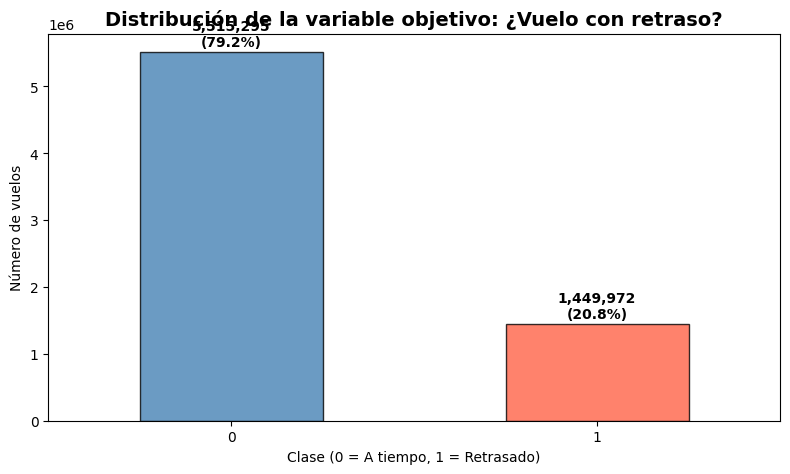


💡 INTERPRETACIÓN Y RECOMENDACIONES:
   ⚠️  Leve desbalance. Recomendado usar AUC, F1-score o recall como métrica principal.

🔧 Sugerencia para XGBoost: usa scale_pos_weight = 3.80


In [12]:
# === ANÁLISIS DEL BALANCE DE CLASES EN LA VARIABLE OBJETIVO ===
print("\n" + "="*60)
print("⚖️  ANÁLISIS DEL BALANCE DE CLASES: VARIABLE 'RETRASO'")
print("="*60)

try:
    # Validar que df_encoded exista y contenga 'retraso'
    if 'df_encoded' not in locals() and 'df_encoded' not in globals():
        raise ValueError("DataFrame 'df_encoded' no encontrado. Ejecuta primero el encoding.")
    if 'retraso' not in df_encoded.columns:
        raise ValueError("Variable objetivo 'retraso' no encontrada en el dataset codificado.")

    y = df_encoded['retraso']

    # Contar valores por clase
    conteo_clases = y.value_counts().sort_index()
    total = len(y)

    print(f"📊 Total de observaciones: {total:,}")
    print("\nDistribución de clases:")
    for clase, conteo in conteo_clases.items():
        porcentaje = (conteo / total) * 100
        print(f"   • Clase {clase} (retraso={'Sí' if clase == 1 else 'No'}): {conteo:,} ({porcentaje:.2f}%)")

    # Calcular métricas de desbalance
    proporcion_mayoritaria = conteo_clases.max() / total
    proporcion_minoritaria = conteo_clases.min() / total
    ratio_desbalance = proporcion_mayoritaria / proporcion_minoritaria

    print(f"\n🔍 Métricas de desbalance:")
    print(f"   • Proporción clase mayoritaria: {proporcion_mayoritaria:.2%}")
    print(f"   • Proporción clase minoritaria: {proporcion_minoritaria:.2%}")
    print(f"   • Ratio de desbalance (mayor/minor): {ratio_desbalance:.1f}:1")

    # === VISUALIZACIÓN ===
    plt.figure(figsize=(8, 5))
    colores = ['steelblue', 'tomato'] if len(conteo_clases) == 2 else 'husl'
    conteo_clases.plot(kind='bar', color=colores, edgecolor='black', alpha=0.8)
    plt.title("Distribución de la variable objetivo: ¿Vuelo con retraso?", fontsize=14, weight='bold')
    plt.xlabel("Clase (0 = A tiempo, 1 = Retrasado)")
    plt.ylabel("Número de vuelos")
    plt.xticks(rotation=0)
    for i, v in enumerate(conteo_clases.values):
        plt.text(i, v + total*0.005, f"{v:,}\n({v/total:.1%})", ha='center', va='bottom', fontweight='bold')
    plt.tight_layout()
    plt.show()

    # === INTERPRETACIÓN Y RECOMENDACIONES ===
    print("\n" + "💡 INTERPRETACIÓN Y RECOMENDACIONES:")
    if ratio_desbalance < 1.5:
        print("   ✅ Clases balanceadas. Puedes usar métricas estándar (accuracy, AUC).")
    elif ratio_desbalance < 5:
        print("   ⚠️  Leve desbalance. Recomendado usar AUC, F1-score o recall como métrica principal.")
    elif ratio_desbalance < 20:
        print("   ⚠️⚠️  Desbalance moderado. Considera técnicas como:")
        print("        • Submuestreo de la clase mayoritaria")
        print("        • Sobremuestreo de la clase minoritaria (SMOTE)")
        print("        • Uso de pesos de clase (class_weight='balanced')")
    else:
        print("   ❗ Desbalance severo. Se requiere tratamiento especial:")
        print("        • SMOTE + submuestreo híbrido")
        print("        • Modelos sensibles al desbalance (XGBoost con scale_pos_weight)")
        print("        • Enfoque en recall o precisión según el caso de uso")

    # Calcular weight para XGBoost (si es binario)
    if len(conteo_clases) == 2:
        neg, pos = conteo_clases[0], conteo_clases[1]
        scale_pos_weight = neg / pos
        print(f"\n🔧 Sugerencia para XGBoost: usa scale_pos_weight = {scale_pos_weight:.2f}")

except Exception as e:
    print(f"❌ Error en el análisis de balance: {str(e)}")

In [13]:
print("\n" + "="*60)
print("⚖️  BALANCEO DE CLASES: TÉCNICAS EFICIENTES EN RAM")
print("="*60)

# Validar que df_encoded y 'retraso' existan
if 'df_encoded' not in locals() or 'retraso' not in df_encoded.columns:
    print("❌ Error: df_encoded o variable 'retraso' no disponibles.")
else:
    X = df_encoded.drop(columns=['retraso'])
    y = df_encoded['retraso'].copy()

    print(f"📊 Dataset original: {X.shape[0]:,} muestras")
    print(f"   • Clase 0 (a tiempo): {(y == 0).sum():,}")
    print(f"   • Clase 1 (retraso): {(y == 1).sum():,}")

    # === OPCIÓN 1: USAR PONDERACIÓN DE CLASES (RECOMENDADO PARA GRANDES DATASETS) ===
    print("\n" + "-"*50)
    print("🔧 OPCIÓN 1: PONDERACIÓN DE CLASES (sin modificar datos)")
    print("-"*50)

    # Calcular class_weight de forma manual (compatible con cualquier modelo)
    neg, pos = (y == 0).sum(), (y == 1).sum()
    class_weight = {0: 1, 1: neg / pos}
    print(f"✅ Peso para clase 0 (a tiempo): {class_weight[0]:.2f}")
    print(f"✅ Peso para clase 1 (retraso): {class_weight[1]:.2f}")
    print("💡 Usar class_weight en modelos (RandomForest, XGBoost, etc.)")

    # Guardar para uso posterior
    balance_config = {
        'estrategia': 'class_weight',
        'class_weight': class_weight,
        'X_train': None,  # Se definirá en train/test split
        'y_train': None
    }

    # === OPCIÓN 2: SUBMUESTREO ALEATORIO (SI RAM ES CRÍTICA) ===
    print("\n" + "-"*50)
    print("🔄 OPCIÓN 2: SUBMUESTREO ALEATORIO (reduce tamaño del dataset)")
    print("-"*50)

    # Calcular el tamaño objetivo: igualar clases (1:1) o mantener 2:1
    ratio_objetivo = 1.0  # 1.0 = balance perfecto, 2.0 = 2x más mayoría
    n_minoritaria = pos
    n_mayoritaria_objetivo = int(n_minoritaria * ratio_objetivo)

    print(f"🎯 Objetivo: {n_mayoritaria_objetivo:,} muestras en clase mayoritaria (ratio {ratio_objetivo}:1)")

    if n_mayoritaria_objetivo >= neg:
        print("ℹ️  No se requiere submuestreo (ratio ya aceptable).")
        X_sub, y_sub = X, y
    else:
        try:
            # Separar índices
            idx_mayoritaria = y[y == 0].index
            idx_minoritaria = y[y == 1].index

            # Submuestrear clase mayoritaria
            idx_mayoritaria_sub = resample(
                idx_mayoritaria,
                replace=False,
                n_samples=n_mayoritaria_objetivo,
                random_state=42
            )

            # Combinar índices
            idx_balanceado = np.concatenate([idx_mayoritaria_sub, idx_minoritaria])
            X_sub = X.loc[idx_balanceado].copy()
            y_sub = y.loc[idx_balanceado].copy()

            print(f"✅ Submuestreo completado: {X_sub.shape[0]:,} muestras totales")
            print(f"   • Clase 0: {sum(y_sub == 0):,}")
            print(f"   • Clase 1: {sum(y_sub == 1):,}")

            # Liberar memoria
            del idx_mayoritaria, idx_minoritaria, idx_mayoritaria_sub, idx_balanceado
            gc.collect()

        except Exception as e:
            print(f"⚠️  Error en submuestreo: {e}")
            X_sub, y_sub = X, y

    # === RESUMEN ===
    print("\n" + "="*60)
    print("📌 RESUMEN DE ESTRATEGIAS")
    print("="*60)
    print("1️⃣  PONDERACIÓN DE CLASES:")
    print("    - No modifica los datos")
    print(f"    - class_weight = {{0: 1, 1: {class_weight[1]:.2f}}}")
    print("    - Ideal para XGBoost, RandomForest, etc.")
    print("\n2️⃣  SUBMUESTREO:")
    print(f"    - Reduce dataset a {X_sub.shape[0]:,} filas")
    print("    - Ahorra RAM, pero pierde información")
    print("\n✅ RECOMENDACIÓN: Usa PONDERACIÓN DE CLASES (más robusto y eficiente)")

    # Guardar datos submuestreados (opcional)
    df_balanceado = pd.concat([X_sub, y_sub], axis=1)

    # Liberar X, y originales si usas submuestreo
    del X, y
    gc.collect()

    print("\n💾 Dataset balanceado (submuestreo) guardado en 'df_balanceado'")
    print(f"📊 Tamaño final: {df_balanceado.shape[0]:,} filas, {df_balanceado.shape[1]} columnas")

    # Nota: para usar SMOTE, se requeriría más RAM → no recomendado en Colab con datasets grandes
    print("\n❗ Nota: SMOTE no se aplica aquí por alto consumo de RAM en datasets grandes.")


⚖️  BALANCEO DE CLASES: TÉCNICAS EFICIENTES EN RAM
📊 Dataset original: 6,965,267 muestras
   • Clase 0 (a tiempo): 5,515,295
   • Clase 1 (retraso): 1,449,972

--------------------------------------------------
🔧 OPCIÓN 1: PONDERACIÓN DE CLASES (sin modificar datos)
--------------------------------------------------
✅ Peso para clase 0 (a tiempo): 1.00
✅ Peso para clase 1 (retraso): 3.80
💡 Usar class_weight en modelos (RandomForest, XGBoost, etc.)

--------------------------------------------------
🔄 OPCIÓN 2: SUBMUESTREO ALEATORIO (reduce tamaño del dataset)
--------------------------------------------------
🎯 Objetivo: 1,449,972 muestras en clase mayoritaria (ratio 1.0:1)
✅ Submuestreo completado: 2,899,944 muestras totales
   • Clase 0: 1,449,972
   • Clase 1: 1,449,972

📌 RESUMEN DE ESTRATEGIAS
1️⃣  PONDERACIÓN DE CLASES:
    - No modifica los datos
    - class_weight = {0: 1, 1: 3.80}
    - Ideal para XGBoost, RandomForest, etc.

2️⃣  SUBMUESTREO:
    - Reduce dataset a 2,899,944


🔗 ANÁLISIS DE CORRELACIÓN ENTRE VARIABLES NUMÉRICAS
📊 Variables numéricas incluidas: 11
   → op_unique_carrier, origin, dest, distance, hora_salida_programada...


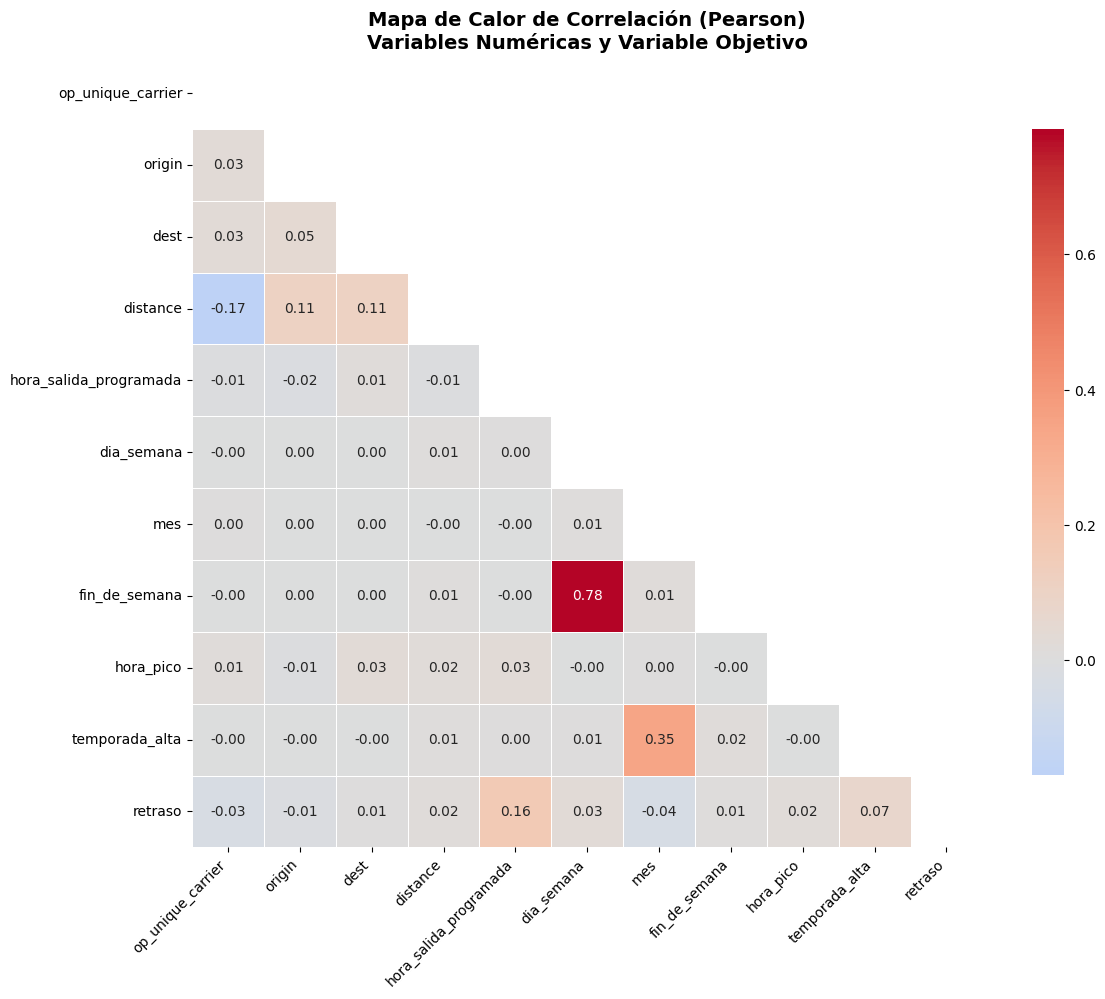


🔍 Correlación con la variable objetivo 'retraso':
   • hora_salida_programada: 0.162 (positiva)

💡 INSIGHTS:
• Correlaciones > |0.7| indican multicolinealidad (pueden afectar modelos lineales).
• Variables con alta correlación con 'retraso' son buenas candidatas para el modelo.
• Los retrasos suelen estar fuertemente correlacionados con 'dep_delay', 'carrier_delay', etc.


In [14]:


print("\n" + "="*60)
print("🔗 ANÁLISIS DE CORRELACIÓN ENTRE VARIABLES NUMÉRICAS")
print("="*60)

try:
    # Validar que df_encoded exista
    if 'df_encoded' not in locals() and 'df_encoded' not in globals():
        raise ValueError("DataFrame 'df_encoded' no encontrado. Ejecuta primero el encoding.")

    # Seleccionar solo columnas numéricas (excluir 'retraso' por ahora, se añadirá después)
    numeric_cols = df_encoded.select_dtypes(include=[np.number]).columns.tolist()

    if 'retraso' in numeric_cols:
        # Mover 'retraso' al final para que aparezca en el heatmap
        numeric_cols = [col for col in numeric_cols if col != 'retraso'] + ['retraso']

    if len(numeric_cols) < 2:
        raise ValueError("No hay suficientes variables numéricas para calcular correlación.")

    print(f"📊 Variables numéricas incluidas: {len(numeric_cols)}")
    print(f"   → {', '.join(numeric_cols[:5])}" + ("..." if len(numeric_cols) > 5 else ""))

    # Calcular matriz de correlación (Pearson)
    corr_matrix = df_encoded[numeric_cols].corr()

    # === VISUALIZACIÓN: MAPA DE CALOR ===
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Mostrar solo triángulo inferior
    sns.heatmap(
        corr_matrix,
        mask=mask,
        annot=True,
        fmt=".2f",
        cmap='coolwarm',
        center=0,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.8}
    )
    plt.title("Mapa de Calor de Correlación (Pearson)\nVariables Numéricas y Variable Objetivo", fontsize=14, weight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # === ANÁLISIS: CORRELACIÓN CON LA VARIABLE OBJETIVO ===
    print("\n🔍 Correlación con la variable objetivo 'retraso':")
    if 'retraso' in corr_matrix.columns:
        corr_con_retraso = corr_matrix['retraso'].drop('retraso').sort_values(key=abs, ascending=False)
        for var, valor in corr_con_retraso.items():
            if abs(valor) > 0.1:  # Solo mostrar correlaciones relevantes
                direccion = "positiva" if valor > 0 else "negativa"
                print(f"   • {var}: {valor:.3f} ({direccion})")
        if all(abs(corr_con_retraso) <= 0.1):
            print("   Ninguna variable muestra correlación fuerte (>|0.1|) con 'retraso'.")
    else:
        print("⚠️  'retraso' no está en la matriz de correlación.")

    # === INSIGHTS CLAVE ===
    print("\n💡 INSIGHTS:")
    print("• Correlaciones > |0.7| indican multicolinealidad (pueden afectar modelos lineales).")
    print("• Variables con alta correlación con 'retraso' son buenas candidatas para el modelo.")
    print("• Los retrasos suelen estar fuertemente correlacionados con 'dep_delay', 'carrier_delay', etc.")

except Exception as e:
    print(f"❌ Error en el análisis de correlación: {str(e)}")


🎯 ANÁLISIS DE CORRELACIÓN CON LA VARIABLE OBJETIVO 'RETRASO'
📊 Analizando correlación de 10 variables numéricas con 'retraso'...


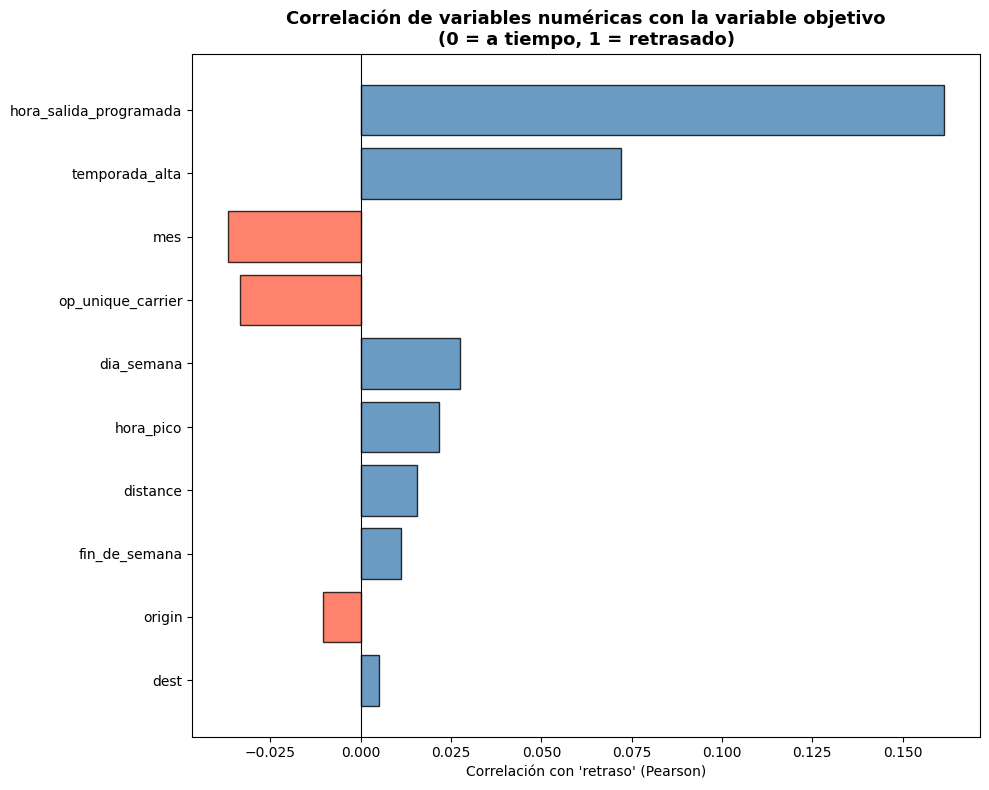


🔍 Clasificación por fuerza de correlación con 'retraso':

💪 No hay correlaciones fuertes (|r| ≥ 0.3).

📊 Correlaciones MODERADAS (0.1 ≤ |r| < 0.3):
   • hora_salida_programada: 0.162 (positiva ↑)

📏 Correlaciones débiles (|r| < 0.1): 9 variables (no mostradas)

🏆 Top 10 predictores más correlacionados con 'retraso':
   1. hora_salida_programada = 0.162 ↑
   2. temporada_alta = 0.072 ↑
   3. mes = -0.037 ↓
   4. op_unique_carrier = -0.033 ↓
   5. dia_semana = 0.028 ↑
   6. hora_pico = 0.022 ↑
   7. distance = 0.016 ↑
   8. fin_de_semana = 0.011 ↑
   9. origin = -0.010 ↓
   10. dest = 0.005 ↑

💡 INTERPRETACIÓN:
• Correlación positiva ↑: mayor valor → más probabilidad de retraso.
• Correlación negativa ↓: mayor valor → menos probabilidad de retraso.
• En datos de vuelos, 'dep_delay' y 'carrier_delay' suelen ser los predictores más fuertes.


In [15]:
# === ANÁLISIS DE CORRELACIÓN CON LA VARIABLE OBJETIVO ===


print("\n" + "="*60)
print("🎯 ANÁLISIS DE CORRELACIÓN CON LA VARIABLE OBJETIVO 'RETRASO'")
print("="*60)

try:
    # Validar disponibilidad del dataset
    if 'df_encoded' not in locals() and 'df_encoded' not in globals():
        raise ValueError("DataFrame 'df_encoded' no encontrado. Ejecuta primero el encoding.")
    if 'retraso' not in df_encoded.columns:
        raise ValueError("Variable objetivo 'retraso' no encontrada.")

    # Seleccionar solo variables numéricas (excluir la propia 'retraso' del listado de predictores)
    numeric_cols = df_encoded.select_dtypes(include=[np.number]).columns.tolist()
    predictor_cols = [col for col in numeric_cols if col != 'retraso']

    if not predictor_cols:
        raise ValueError("No se encontraron variables numéricas además de 'retraso'.")

    print(f"📊 Analizando correlación de {len(predictor_cols)} variables numéricas con 'retraso'...")

    # Calcular correlación (Pearson) con la variable objetivo
    corr_with_target = df_encoded[predictor_cols].corrwith(df_encoded['retraso']).sort_values(key=abs, ascending=False)

    # Convertir a DataFrame para facilitar visualización
    corr_df = pd.DataFrame({
        'variable': corr_with_target.index,
        'correlacion': corr_with_target.values,
        'abs_correlacion': corr_with_target.abs().values
    })

    # === VISUALIZACIÓN: BARRAS DE CORRELACIÓN ===
    plt.figure(figsize=(10, 8))
    colors = ['tomato' if x < 0 else 'steelblue' for x in corr_df['correlacion']]
    plt.barh(corr_df['variable'], corr_df['correlacion'], color=colors, edgecolor='black', alpha=0.8)
    plt.xlabel("Correlación con 'retraso' (Pearson)")
    plt.title("Correlación de variables numéricas con la variable objetivo\n(0 = a tiempo, 1 = retrasado)", fontsize=13, weight='bold')
    plt.axvline(0, color='black', linewidth=0.8)
    plt.gca().invert_yaxis()  # Más importante arriba
    plt.tight_layout()
    plt.show()

    # === CLASIFICACIÓN POR FUERZA DE CORRELACIÓN ===
    print("\n🔍 Clasificación por fuerza de correlación con 'retraso':")

    fuertes = corr_df[corr_df['abs_correlacion'] >= 0.3]
    moderadas = corr_df[(corr_df['abs_correlacion'] >= 0.1) & (corr_df['abs_correlacion'] < 0.3)]
    debiles = corr_df[corr_df['abs_correlacion'] < 0.1]

    if not fuertes.empty:
        print(f"\n💪 Correlaciones FUERTES (|r| ≥ 0.3):")
        for _, row in fuertes.iterrows():
            dir_txt = "positiva ↑" if row['correlacion'] > 0 else "negativa ↓"
            print(f"   • {row['variable']}: {row['correlacion']:.3f} ({dir_txt})")
    else:
        print("\n💪 No hay correlaciones fuertes (|r| ≥ 0.3).")

    if not moderadas.empty:
        print(f"\n📊 Correlaciones MODERADAS (0.1 ≤ |r| < 0.3):")
        for _, row in moderadas.iterrows():
            dir_txt = "positiva ↑" if row['correlacion'] > 0 else "negativa ↓"
            print(f"   • {row['variable']}: {row['correlacion']:.3f} ({dir_txt})")

    print(f"\n📏 Correlaciones débiles (|r| < 0.1): {len(debiles)} variables (no mostradas)")

    # === TOP 10 VARIABLES MÁS CORRELACIONADAS ===
    top5 = corr_df.head(10)
    print(f"\n🏆 Top 10 predictores más correlacionados con 'retraso':")
    for i, (_, row) in enumerate(top5.iterrows(), 1):
        dir_emoji = "↑" if row['correlacion'] > 0 else "↓"
        print(f"   {i}. {row['variable']} = {row['correlacion']:.3f} {dir_emoji}")

    # === INTERPRETACIÓN ===
    print("\n" + "💡 INTERPRETACIÓN:")
    print("• Correlación positiva ↑: mayor valor → más probabilidad de retraso.")
    print("• Correlación negativa ↓: mayor valor → menos probabilidad de retraso.")
    print("• En datos de vuelos, 'dep_delay' y 'carrier_delay' suelen ser los predictores más fuertes.")

except Exception as e:
    print(f"❌ Error en el análisis de correlación con la variable objetivo: {str(e)}")

In [16]:
# SEPARACIÓN DE DATOS
# Dividir el conjunto de datos en entrenamiento y prueba



print("\n" + "="*60)
print("✂️  SEPARACIÓN DE DATOS: TRAIN Y TEST")
print("="*60)

try:
    # Buscar el DataFrame más adecuado disponible
    df_usar = None
    if 'df_encoded' in locals() or 'df_encoded' in globals():
        df_usar = df_encoded
        print("✅ Usando 'df_encoded' para la división.")
    elif 'df' in locals() or 'df' in globals():
        df_usar = df
        print("⚠️  'df_encoded' no encontrado. Usando 'df' como fuente.")
    else:
        raise ValueError("Ni 'df_encoded' ni 'df' están disponibles. Ejecuta la carga y preparación.")


    # Preparar X e y
    X = df_usar.drop(columns=['retraso'])
    y = df_usar['retraso']

    print(f"📊 Dataset completo: {X.shape[0]:,} muestras, {X.shape[1]} características")
    print(f"🎯 Proporción de retrasos: {y.mean():.2%}")

    # Dividir con estratificación
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        stratify=y,
        random_state=42,
        shuffle=True
    )

    print(f"\n✅ División completada:")
    print(f"   • Train: {X_train.shape[0]:,} muestras ({X_train.shape[0]/len(X):.1%})")
    print(f"     - Retrasos en train: {y_train.mean():.2%}")
    print(f"   • Test:  {X_test.shape[0]:,} muestras ({X_test.shape[0]/len(X):.1%})")
    print(f"     - Retrasos en test:  {y_test.mean():.2%}")

    # Verificar proporciones
    diff_prop = abs(y_train.mean() - y_test.mean())
    if diff_prop < 0.001:
        print("✅ Proporción de clases preservada correctamente en train/test.")
    else:
        print(f"⚠️  Pequeña diferencia en proporciones: {diff_prop:.4f}")

    # Liberar el DataFrame original para ahorrar RAM
    if 'df_encoded' in locals() or 'df_encoded' in globals():
        del df_encoded
    if 'df' in locals() or 'df' in globals():
        del df
    gc.collect()
    print("\n🧹 DataFrames originales eliminados. Solo se mantienen X_train, X_test, y_train, y_test.")

except Exception as e:
    print(f"❌ Error al dividir los datos: {str(e)}")
    X_train = X_test = y_train = y_test = None


✂️  SEPARACIÓN DE DATOS: TRAIN Y TEST
✅ Usando 'df_encoded' para la división.
📊 Dataset completo: 6,965,267 muestras, 12 características
🎯 Proporción de retrasos: 20.82%

✅ División completada:
   • Train: 5,572,213 muestras (80.0%)
     - Retrasos en train: 20.82%
   • Test:  1,393,054 muestras (20.0%)
     - Retrasos en test:  20.82%
✅ Proporción de clases preservada correctamente en train/test.

🧹 DataFrames originales eliminados. Solo se mantienen X_train, X_test, y_train, y_test.


In [17]:

# CREACIÓN DE MODELOS PREDICTIVOS (SIN DATA LEAKAGE)
# Solo usa variables disponibles ANTES de la salida del vuelo

print("\n" + "="*60)
print("🤖 CREACIÓN DE MODELOS (FEATURES SIN LEAKAGE)")
print("="*60)

# === 1. VERIFICAR DATOS ===
if not all(var in globals() for var in ['X_train', 'X_test', 'y_train', 'y_test']):
    print("❌ Error: Conjuntos de train/test no encontrados.")
    print("⚠️  Ejecuta primero el bloque de separación de datos.")
    modelos = {}
    umbral_optimo_xgb = 0.5  # valor por defecto óptimo. Bajar para aumentar recall, subir para aumentar precisión.
else:
    print("✅ Conjuntos de train/test disponibles.")

    # === 2. DEFINIR FEATURES SEGURAS (sin leakage) ===
    features_seguras = [
'hora_salida_programada',
'temporada_alta',
'op_unique_carrier',
'mes',
'dia_semana',
'hora_pico',
'origin',
'dest'
]
    # Filtrar solo las features seguras que existan
    features_existentes = [col for col in features_seguras if col in X_train.columns]
    print(f"✅ Usando {len(features_existentes)} features seguras (sin leakage):")
    print(f"   → {', '.join(features_existentes)}")

    X_train_seguro = X_train[features_existentes].copy()
    X_test_seguro = X_test[features_existentes].copy()
    y_train_seguro = y_train.copy()
    y_test_seguro = y_test.copy()

    # === 3. PREPROCESAR CATEGÓRICAS (Label Encoding) ===
    print("\n🧹 Codificando variables categóricas...")
    cat_cols = X_train_seguro.select_dtypes(include=['object', 'category']).columns.tolist()

    if cat_cols:
        for col in cat_cols:
            # Asegurar que train y test usen el mismo encoder
            all_vals = pd.concat([X_train_seguro[col], X_test_seguro[col]]).astype(str).unique()
            le = LabelEncoder().fit(all_vals)
            X_train_seguro[col] = le.transform(X_train_seguro[col].astype(str))
            X_test_seguro[col] = le.transform(X_test_seguro[col].astype(str))
        print("✅ Codificación completada.")

    # Convertir a numérico (por si hay strings residuales)
    X_train_seguro = X_train_seguro.apply(pd.to_numeric, errors='coerce').fillna(-1)
    X_test_seguro = X_test_seguro.apply(pd.to_numeric, errors='coerce').fillna(-1)

    # === 4. ENTRENAR MODELOS ===
    modelos = {}
    metricas = {}
    umbral_optimo_xgb = 0.5  # valor por defecto

    # --- XGBoost (recomendado) ---
    print("\n" + "-"*50)
    print("⚡ Entrenando XGBoost (features sin leakage)...")
    try:
        neg, pos = (y_train_seguro == 0).sum(), (y_train_seguro == 1).sum()
        scale_pos_weight = neg / pos

        print(f"📊 Distribución en train (tras corrección >=15):")
        print(f"   • A tiempo (0): {neg:,}")
        print(f"   • Retraso (1): {pos:,}")
        print(f"   • scale_pos_weight = {scale_pos_weight:.2f}")

        xgb_model = xgb.XGBClassifier(
            n_estimators=200,
            max_depth=6,
            learning_rate=0.1,
            scale_pos_weight=scale_pos_weight,
            random_state=42,
            use_label_encoder=False,
            eval_metric='aucpr'
        )
        xgb_model.fit(X_train_seguro, y_train_seguro)
        y_proba_xgb = xgb_model.predict_proba(X_test_seguro)[:, 1]

        # === 🔥 AJUSTE DE UMBRAL PARA MAXIMIZAR F1-SCORE ===
        from sklearn.metrics import precision_recall_curve, f1_score
        import numpy as np

        precision_vals, recall_vals, thresholds = precision_recall_curve(y_test_seguro, y_proba_xgb)
        f1_scores = 2 * (precision_vals * recall_vals) / (precision_vals + recall_vals + 1e-10)
        best_idx = np.argmax(f1_scores)
        umbral_optimo_xgb = thresholds[best_idx] if best_idx < len(thresholds) else 0.5

        # Aplicar umbral óptimo
        y_pred_xgb = (y_proba_xgb >= umbral_optimo_xgb).astype(int)

        print(f"🎯 Umbral óptimo para F1: {umbral_optimo_xgb:.3f}")

        metricas['XGBoost'] = {
            'AUC': roc_auc_score(y_test_seguro, y_proba_xgb),
            'F1': f1_score(y_test_seguro, y_pred_xgb),
            'Recall': recall_score(y_test_seguro, y_pred_xgb),
            'Precision': precision_score(y_test_seguro, y_pred_xgb)
        }
        modelos['XGBoost'] = (xgb_model, y_pred_xgb, y_proba_xgb)
        print(f"✅ AUC: {metricas['XGBoost']['AUC']:.4f} | F1: {metricas['XGBoost']['F1']:.4f}")
        print(f"   🔧 scale_pos_weight = {scale_pos_weight:.2f} | Umbral = {umbral_optimo_xgb:.3f}")

    except Exception as e:
        print(f"❌ Error en XGBoost: {e}")

   # --- Random Forest (ligero) ---
#    print("\n" + "-"*50)
#    print("🌳 Entrenando Random Forest (rápido)...")
#    try:
#        rf = RandomForestClassifier(
#            n_estimators=50,
#            max_depth=8,
#            min_samples_split=500,
#            min_samples_leaf=250,
#            class_weight='balanced',
#            random_state=42,
#            n_jobs=-1
#        )
#        rf.fit(X_train_seguro, y_train_seguro)
#        y_pred_rf = rf.predict(X_test_seguro)
#        y_proba_rf = rf.predict_proba(X_test_seguro)[:, 1]
##        metricas['Random Forest'] = {
#            'AUC': roc_auc_score(y_test_seguro, y_proba_rf),
#            'F1': f1_score(y_test_seguro, y_pred_rf),
#            'Recall': recall_score(y_test_seguro, y_pred_rf)
#        }
#        modelos['Random Forest'] = (rf, y_pred_rf, y_proba_rf)
#        print(f"✅ AUC: {metricas['Random Forest']['AUC']:.4f} | F1: {metricas['Random Forest']['F1']:.4f}")
##    except Exception as e:
#        print(f"❌ Error en Random Forest: {e}")

    # === 5. GUARDAR RESULTADOS PARA EVALUACIÓN ===
    if modelos:
        globals()['y_test_eval'] = y_test_seguro
        globals()['umbral_optimo_xgb'] = umbral_optimo_xgb  # ← ¡clave para producción!
        for nombre, (modelo, y_pred, y_proba) in modelos.items():
            globals()[f'modelo_{nombre.lower().replace(" ", "_")}'] = modelo
            globals()[f'y_pred_{nombre.lower().replace(" ", "_")}'] = y_pred
            globals()[f'y_proba_{nombre.lower().replace(" ", "_")}'] = y_proba
        print("\n✅ Modelos entrenados y listos para evaluación.")
        print(f"   🎯 Umbral óptimo de XGBoost guardado en 'umbral_optimo_xgb' = {umbral_optimo_xgb:.3f}")
    else:
        print("❌ No se entrenó ningún modelo.")

    # Liberar memoria
    del X_train_seguro, X_test_seguro, y_train_seguro, y_test_seguro
    gc.collect()


🤖 CREACIÓN DE MODELOS (FEATURES SIN LEAKAGE)
✅ Conjuntos de train/test disponibles.
✅ Usando 8 features seguras (sin leakage):
   → hora_salida_programada, temporada_alta, op_unique_carrier, mes, dia_semana, hora_pico, origin, dest

🧹 Codificando variables categóricas...

--------------------------------------------------
⚡ Entrenando XGBoost (features sin leakage)...
📊 Distribución en train (tras corrección >=15):
   • A tiempo (0): 4,412,236
   • Retraso (1): 1,159,977
   • scale_pos_weight = 3.80
🎯 Umbral óptimo para F1: 0.509
✅ AUC: 0.6964 | F1: 0.4288
   🔧 scale_pos_weight = 3.80 | Umbral = 0.509

✅ Modelos entrenados y listos para evaluación.
   🎯 Umbral óptimo de XGBoost guardado en 'umbral_optimo_xgb' = 0.509



🔍 EVALUACIÓN DE MODELOS: ENFOQUE EN DESEQUILIBRIO
✅ Evaluando 1 modelo(s): ['XGBoost']

📊 XGBoost:
   • AUC-ROC: 0.6964 | AUC-PR: 0.3781
   • F1: 0.4288 | Recall: 0.6188 | Precision: 0.3281

📈 TABLA COMPARATIVA DE MÉTRICAS
 Modelo  AUC-ROC  AUC-PR  F1-Score  Recall  Precision  Accuracy
XGBoost   0.6964  0.3781    0.4288  0.6188     0.3281    0.6568


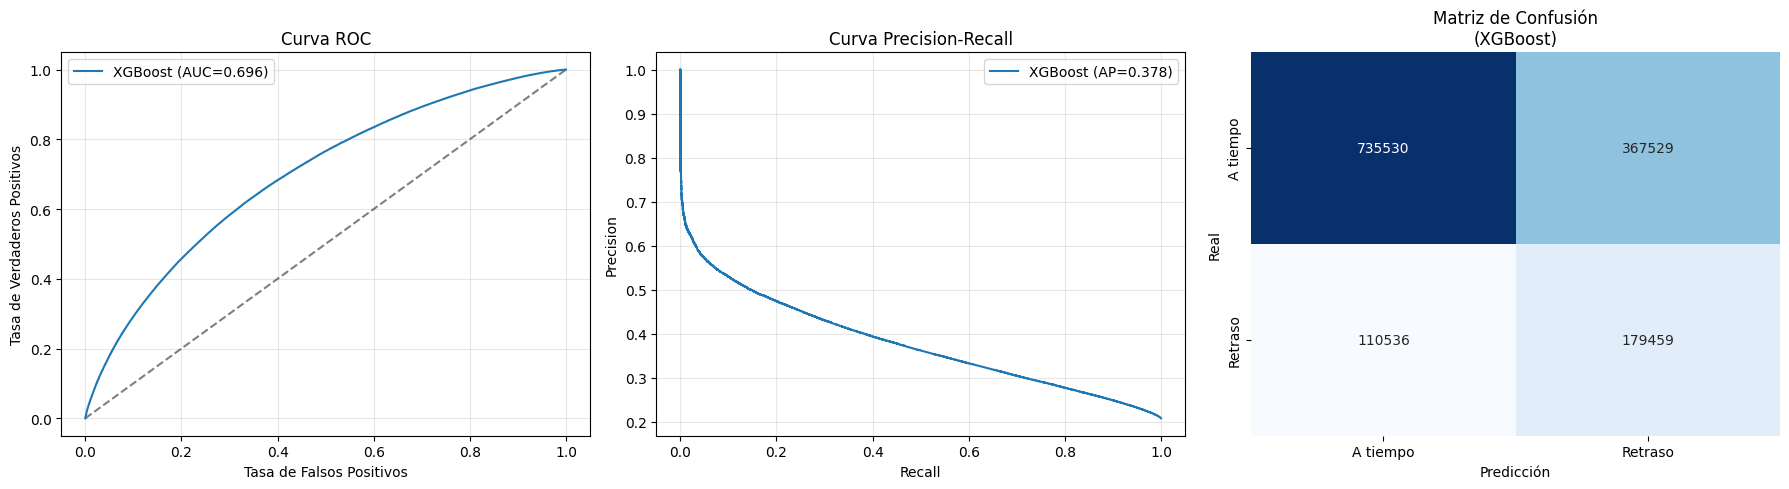


📋 REPORTE DE CLASIFICACIÓN: XGBoost
              precision    recall  f1-score   support

    A tiempo       0.87      0.67      0.75   1103059
     Retraso       0.33      0.62      0.43    289995

    accuracy                           0.66   1393054
   macro avg       0.60      0.64      0.59   1393054
weighted avg       0.76      0.66      0.69   1393054


💡 INTERPRETACIÓN PARA OPERACIONES AÉREAS:
• El modelo identifica correctamente el 61.9% de los vuelos que se retrasan (Recall).
• El 32.8% de los vuelos predichos como 'retrasados' realmente lo están (Precision).

--------------------------------------------------
📈 F1-SCORE VS UMBRAL DE DECISIÓN (XGBoost)
--------------------------------------------------


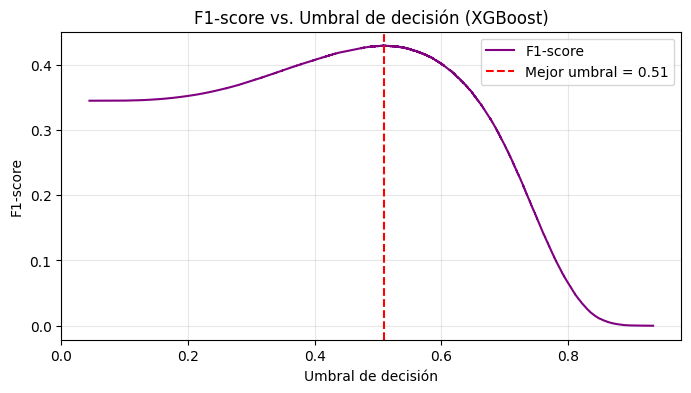

✅ Mejor umbral encontrado: 0.509
   • F1-score máximo: 0.4288


In [18]:

# EVALUACIÓN DE LOS MODELOS (CORREGIDO Y ROBUSTO)

print("\n" + "="*60)
print("🔍 EVALUACIÓN DE MODELOS: ENFOQUE EN DESEQUILIBRIO")
print("="*60)

try:
    if 'y_test' not in globals():
        raise ValueError("❌ y_test no encontrado. Ejecuta primero el modelado.")

    # Detectar modelos disponibles
    modelos_disponibles = {}
    if 'y_pred_xgb' in globals() and 'y_proba_xgb' in globals():
        modelos_disponibles['XGBoost'] = (globals()['y_pred_xgb'], globals()['y_proba_xgb'])
    if 'y_pred_rf' in globals() and 'y_proba_rf' in globals():
        modelos_disponibles['Random Forest'] = (globals()['y_pred_rf'], globals()['y_proba_rf'])

    if not modelos_disponibles:
        raise ValueError("❌ No se encontraron predicciones de modelos.")

    print(f"✅ Evaluando {len(modelos_disponibles)} modelo(s): {list(modelos_disponibles.keys())}")

    resultados = []

    for nombre, (y_pred, y_proba) in modelos_disponibles.items():
        # Asegurar que las métricas sean escalares (promedio binario)
        auc_val = float(roc_auc_score(y_test, y_proba))
        ap_val = float(average_precision_score(y_test, y_proba))
        f1_val = float(f1_score(y_test, y_pred, average='binary'))
        recall_val = float(recall_score(y_test, y_pred, average='binary'))
        precision_val = float(precision_score(y_test, y_pred, average='binary'))
        accuracy_val = float((y_pred == y_test).mean())

        resultados.append({
            'Modelo': nombre,
            'AUC-ROC': auc_val,
            'AUC-PR': ap_val,
            'F1-Score': f1_val,
            'Recall': recall_val,
            'Precision': precision_val,
            'Accuracy': accuracy_val
        })

        print(f"\n📊 {nombre}:")
        print(f"   • AUC-ROC: {auc_val:.4f} | AUC-PR: {ap_val:.4f}")
        print(f"   • F1: {f1_val:.4f} | Recall: {recall_val:.4f} | Precision: {precision_val:.4f}")

    df_metricas = pd.DataFrame(resultados).round(4)
    df_metricas = df_metricas.sort_values('AUC-PR', ascending=False)
    print("\n" + "="*70)
    print("📈 TABLA COMPARATIVA DE MÉTRICAS")
    print("="*70)
    print(df_metricas.to_string(index=False))

    # === VISUALIZACIONES ===
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Curva ROC
    axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
    for nombre, (_, y_proba) in modelos_disponibles.items():
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc_val = roc_auc_score(y_test, y_proba)
        axes[0].plot(fpr, tpr, label=f"{nombre} (AUC={auc_val:.3f})")
    axes[0].set_xlabel("Tasa de Falsos Positivos")
    axes[0].set_ylabel("Tasa de Verdaderos Positivos")
    axes[0].set_title("Curva ROC")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Curva Precision-Recall
    for nombre, (_, y_proba) in modelos_disponibles.items():
        precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_proba)
        ap_val = average_precision_score(y_test, y_proba)
        axes[1].plot(recall_vals, precision_vals, label=f"{nombre} (AP={ap_val:.3f})")
    axes[1].set_xlabel("Recall")
    axes[1].set_ylabel("Precision")
    axes[1].set_title("Curva Precision-Recall")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # Matriz de confusión del mejor modelo
    mejor_modelo = df_metricas.iloc[0]['Modelo']
    y_pred_mejor = modelos_disponibles[mejor_modelo][0]
    cm = confusion_matrix(y_test, y_pred_mejor)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['A tiempo', 'Retraso'],
                yticklabels=['A tiempo', 'Retraso'], ax=axes[2])
    axes[2].set_title(f"Matriz de Confusión\n({mejor_modelo})")
    axes[2].set_ylabel("Real")
    axes[2].set_xlabel("Predicción")

    plt.tight_layout()
    plt.show()

    # === REPORTE DEL MEJOR MODELO ===
    print("\n" + "="*60)
    print(f"📋 REPORTE DE CLASIFICACIÓN: {mejor_modelo}")
    print("="*60)
    print(classification_report(y_test, y_pred_mejor, target_names=['A tiempo', 'Retraso']))

    # === INSIGHTS (usando valores escalares explícitos) ===
    recall_mejor = df_metricas.iloc[0]['Recall']
    precision_mejor = df_metricas.iloc[0]['Precision']
    print("\n" + "💡 INTERPRETACIÓN PARA OPERACIONES AÉREAS:")
    print(f"• El modelo identifica correctamente el {recall_mejor:.1%} de los vuelos que se retrasan (Recall).")
    print(f"• El {precision_mejor:.1%} de los vuelos predichos como 'retrasados' realmente lo están (Precision).")

    # === GRAFICA F1-SCORE VS UMBRAL (solo si XGBoost está disponible) ===
    if 'XGBoost' in modelos_disponibles:
        print("\n" + "-"*50)
        print("📈 F1-SCORE VS UMBRAL DE DECISIÓN (XGBoost)")
        print("-"*50)
        try:
            y_proba_xgb = modelos_disponibles['XGBoost'][1]
            precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_proba_xgb)
            f1_scores = 2 * (precision_vals * recall_vals) / (precision_vals + recall_vals + 1e-10)

            best_idx = np.argmax(f1_scores)
            best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5

            plt.figure(figsize=(8, 4))
            plt.plot(thresholds, f1_scores[:-1], label='F1-score', color='purple')
            plt.axvline(best_threshold, color='red', linestyle='--', label=f'Mejor umbral = {best_threshold:.2f}')
            plt.xlabel('Umbral de decisión')
            plt.ylabel('F1-score')
            plt.title('F1-score vs. Umbral de decisión (XGBoost)')
            plt.legend()
            plt.grid(alpha=0.3)
            plt.show()

            print(f"✅ Mejor umbral encontrado: {best_threshold:.3f}")
            print(f"   • F1-score máximo: {f1_scores[best_idx]:.4f}")

        except Exception as e:
            print(f"⚠️  No se pudo generar la gráfica F1 vs umbral: {e}")

except Exception as e:
    print(f"❌ Error en la evaluación: {str(e)}")
    import traceback
    traceback.print_exc()

In [19]:
# === 6. SERIALIZACIÓN DEL MODELO Y METADATOS ===
print("\n" + "="*60)
print("💾 GUARDANDO MODELO Y METADATOS PARA PRODUCCIÓN")
print("="*60)

import joblib
import json
from datetime import datetime

# Verificar que el modelo XGBoost exista
if 'modelo_xgboost' not in globals() or modelo_xgboost is None:
    print("❌ Error: Modelo XGBoost no encontrado. Ejecuta primero el entrenamiento.")
else:
    try:
        # Nombre del archivo
        model_filename = "flight_delay_model_xgb.pkl"
        metadata_filename = "model_metadata.json"

        # 1. Guardar el modelo
        joblib.dump(modelo_xgboost, model_filename)
        print(f"✅ Modelo guardado: '{model_filename}'")

        # 2. Preparar metadatos
        metadata = {
            "modelo": "XGBoostClassifier",
            "version": "1.0",
            "fecha_entrenamiento": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            "target_definicion": "retraso = (arr_delay >= 15 minutos)",
            "umbral_optimo_f1": float(umbral_optimo_xgb),  # convertir a float nativo
            "features_usadas": features_existentes,
            "clases": ["Puntual", "Retrasado"],  # 0 = Puntual, 1 = Retrasado
            "metricas_test": {
                "AUC": float(metricas['XGBoost']['AUC']),
                "F1": float(metricas['XGBoost']['F1']),
                "Recall": float(metricas['XGBoost']['Recall']),
                "Precision": float(metricas['XGBoost']['Precision'])
            }
        }

        # 3. Guardar metadatos como JSON
        with open(metadata_filename, 'w', encoding='utf-8') as f:
            json.dump(metadata, f, indent=4, ensure_ascii=False)

        print(f"✅ Metadatos guardados: '{metadata_filename}'")

        # 4. Mostrar resumen para el README
        print("\n📋 RESUMEN PARA DOCUMENTACIÓN (README):")
        print(f"• Definición de retraso: {metadata['target_definicion']}")
        print(f"• Features usadas ({len(metadata['features_usadas'])}): {', '.join(metadata['features_usadas'])}")
        print(f"• Umbral óptimo de decisión: {metadata['umbral_optimo_f1']:.3f}")
        print(f"• F1-score en test: {metadata['metricas_test']['F1']:.4f}")

        # Opcional: descargar en Colab
        try:
            from google.colab import files
            print("\n📤 Descargando archivos...")
            files.download(model_filename)
            files.download(metadata_filename)
        except:
            print("ℹ️  Ejecutando localmente (sin descarga automática).")

    except Exception as e:
        print(f"❌ Error al guardar: {e}")
        import traceback
        traceback.print_exc()


💾 GUARDANDO MODELO Y METADATOS PARA PRODUCCIÓN
✅ Modelo guardado: 'flight_delay_model_xgb.pkl'
✅ Metadatos guardados: 'model_metadata.json'

📋 RESUMEN PARA DOCUMENTACIÓN (README):
• Definición de retraso: retraso = (arr_delay >= 15 minutos)
• Features usadas (8): hora_salida_programada, temporada_alta, op_unique_carrier, mes, dia_semana, hora_pico, origin, dest
• Umbral óptimo de decisión: 0.509
• F1-score en test: 0.4288

📤 Descargando archivos...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Prueba de transformación de PKL a Json

In [20]:

import pickle               # <--- Esta línea es la que faltaba
import xgboost as xgb       # También necesitamos esta
import json

# Asegúrate de que el nombre del archivo coincida exactamente con el que subiste
nombre_archivo = 'flight_delay_model_xgb.pkl'

try:
    print(f"Intentando cargar {nombre_archivo}...")

    with open(nombre_archivo, 'rb') as f:
        # Cargamos el modelo completo de scikit-learn
        sklearn_model = pickle.load(f)

    print("Modelo cargado. Extrayendo booster...")

    # Extraer el motor interno de XGBoost
    if hasattr(sklearn_model, 'get_booster'):
        booster = sklearn_model.get_booster()
    else:
        # En caso de que sea un modelo guardado diferente, intentamos acceder directamente
        booster = sklearn_model

    # Guardar como JSON para Java
    archivo_salida = 'modelo_vuelos.json'
    booster.save_model(archivo_salida)

    print(f"¡Éxito! El archivo '{archivo_salida}' ha sido creado.")
    print("Ahora descarga este archivo .json y úsalo en tu proyecto Java.")

except FileNotFoundError:
    print(f"ERROR: No se encuentra el archivo '{nombre_archivo}'.")
    print("Si estás en Google Colab, asegúrate de haber subido el archivo a la carpeta de archivos (icono de carpeta a la izquierda).")
except Exception as e:
    print(f"Ocurrió un error: {e}")

Intentando cargar flight_delay_model_xgb.pkl...
Modelo cargado. Extrayendo booster...
¡Éxito! El archivo 'modelo_vuelos.json' ha sido creado.
Ahora descarga este archivo .json y úsalo en tu proyecto Java.


In [21]:
import pickle               # <--- Esta línea es la que faltaba
import xgboost as xgb       # También necesitamos esta
import json

# Asegúrate de que el nombre del archivo coincida exactamente con el que subiste
nombre_archivo = 'flight_delay_model_xgb.pkl'

try:
    print(f"Intentando cargar {nombre_archivo}...")

    with open(nombre_archivo, 'rb') as f:
        # Cargamos el modelo completo de scikit-learn
        sklearn_model = pickle.load(f)

    print("Modelo cargado. Extrayendo booster...")

    # Extraer el motor interno de XGBoost
    if hasattr(sklearn_model, 'get_booster'):
        booster = sklearn_model.get_booster()
    else:
        # En caso de que sea un modelo guardado diferente, intentamos acceder directamente
        booster = sklearn_model

    # Guardar como JSON para Java
    archivo_salida = 'modelo_vuelos.json'
    booster.save_model(archivo_salida)

    print(f"¡Éxito! El archivo '{archivo_salida}' ha sido creado.")
    print("Ahora descarga este archivo .json y úsalo en tu proyecto Java.")

    # Opcional: descargar en Colab
 #   try:
#        from google.colab import files
 #        print("\n📤 Descargando archivos...")
#        files.download(archivo_salida)
#    except:
#        print("ℹ️  Ejecutando localmente (sin descarga automática).")


except FileNotFoundError:
    print(f"ERROR: No se encuentra el archivo '{nombre_archivo}'.")
    print("Si estás en Google Colab, asegúrate de haber subido el archivo a la carpeta de archivos (icono de carpeta a la izquierda).")
except Exception as e:
    print(f"Ocurrió un error: {e}")

Intentando cargar flight_delay_model_xgb.pkl...
Modelo cargado. Extrayendo booster...
¡Éxito! El archivo 'modelo_vuelos.json' ha sido creado.
Ahora descarga este archivo .json y úsalo en tu proyecto Java.
